PRE-SWOT NUMERICAL SIMULATION VERSION 1 User Guide Demo
===================================================

Author: Jinbo Wang <Jinbo.Wang@jpl.nasa.gov>, Jack McNelis <jack.mcnelis@jpl.nasa.gov>


This is a demonstration of accessing the ECCO-BASED PRE-SWOT NUMERICAL SIMULATION. The dataset can be found following https://search.earthdata.nasa.gov/search?q=pocloud%20pre-swot.


In [7]:
import os
import s3fs
import requests
import xarray as xr
import pylab as plt
from netrc import netrc
from urllib import request
from platform import system
from getpass import getpass
from http.cookiejar import CookieJar
from os.path import expanduser, join

ShortName = "MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0"
ndays = 3 # number of days
target_files = [f"LLC4320_pre-SWOT_ACC_SMST_201112{day}.nc" for day in range(21,21+3)] # list target files

**Earthdata Login**

Authenticate with your Earthdata Login/URS credentials by configuring a *.netrc* file in your home directory.

```
machine urs.earthdata.nasa.gov username myusername password mypassword
```

>*Note this next cell first tries to establish in-region acccess to the netCDF file in S3. (It assumes that you are running the notebook inside AWS EC2 in the `aws-west-2` region.) Upon failure, it assumes that you are running from your local machine, and so it tries to download and open the file the normal way.*

Run the next cell to authenticate. (You might be prompted for your Earthdata Login username and password.)

In [3]:
def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
setup_earthdata_login_auth()

Please provide your Earthdata Login credentials for access.
Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.


Username:  iuryt
Password:  ········


You should now be able to download the file at the following link:

In [8]:
# https access for each target_file
url = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected"
https_accesses = [f"{url}/{ShortName}/{target_file}" for target_file in target_files]
print(https_accesses)

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0/LLC4320_pre-SWOT_ACC_SMST_20111221.nc', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0/LLC4320_pre-SWOT_ACC_SMST_20111222.nc', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MITgcm_LLC4320_Pre-SWOT_JPL_L4_ACC_SMST_v1.0/LLC4320_pre-SWOT_ACC_SMST_20111223.nc']


**Open the dataset**

Run the next cell to access/open the netCDF file with *xarray*:

In [5]:
def begin_s3_direct_access():
    """Returns s3fs object for accessing datasets stored in S3."""
    response = requests.get("https://archive.podaac.earthdata.nasa.gov/s3credentials").json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'], 
                             client_kwargs={'region_name':'us-west-2'})

# list of dataset objects
dds = []
for https_access,target_file in zip(https_accesses,target_files):
    print(target_file) # print file name

    # try to read from AWS and append to dds
    try:
        fs = begin_s3_direct_access()
        # Load netCDF with 's3fs' and 'xarray' upon successful connection to S3:
        dds.append(xr.open_dataset(fs.open(f"podaac-ops-cumulus-protected/{ShortName}/{target_file}")))
    # if not on AWS, it will download data
    except:
        if not(os.path.isfile(target_file)):
            print("Failed to establish AWS in-region access. Downloading to local disk instead.")
            request.urlretrieve(https_access, target_file)
            
# if dds is empty (which means we are not on AWS)
if dds==[]: 
    # Load all netCDF files
    dds = xr.open_mfdataset(target_files)
else:
    # Concatenate all files loaded from AWS
    dds = xr.concat(dds,'time')

LLC4320_pre-SWOT_ACC_SMST_20111221.nc
LLC4320_pre-SWOT_ACC_SMST_20111222.nc
LLC4320_pre-SWOT_ACC_SMST_20111223.nc


Plot eight 2D fields.
-------------------

In [16]:
# select the first time step for plotting
dd0 = dds.isel(time=0).load()

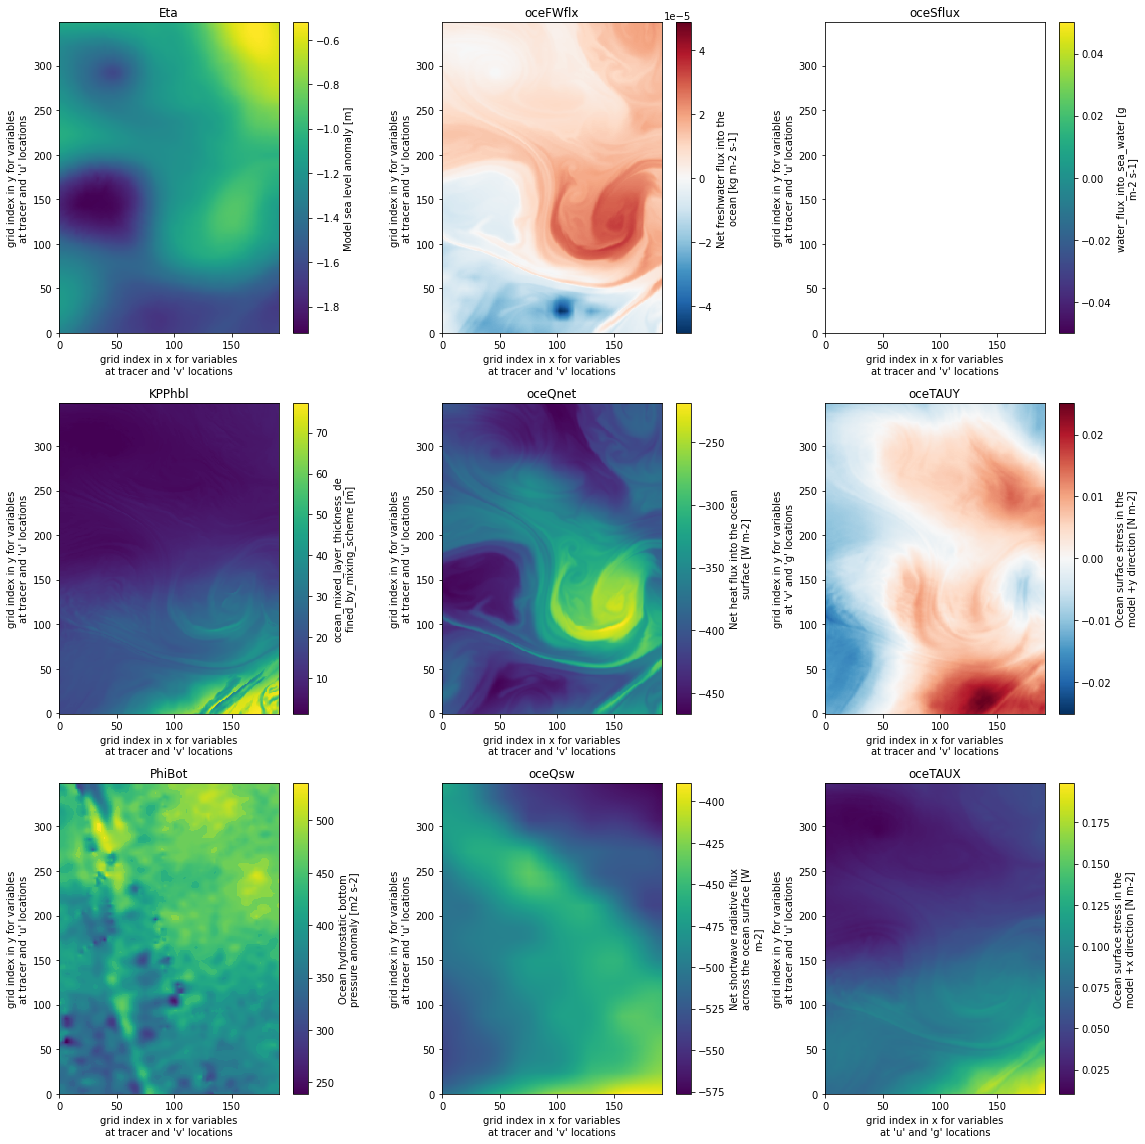

In [17]:
fig,ax=plt.subplots(3,3,figsize=(16,16))

varn=['Eta','KPPhbl','PhiBot','oceFWflx','oceQnet','oceQsw','oceSflux','oceTAUY','oceTAUX']

for i in range(3):
    for j in range(3):
        dd0[varn[i*3+j]].plot(ax=ax[j,i])
        ax[j,i].set_title(varn[i*3+j])
plt.tight_layout()

Plot a 3D field based (temperature)
---------------------------------

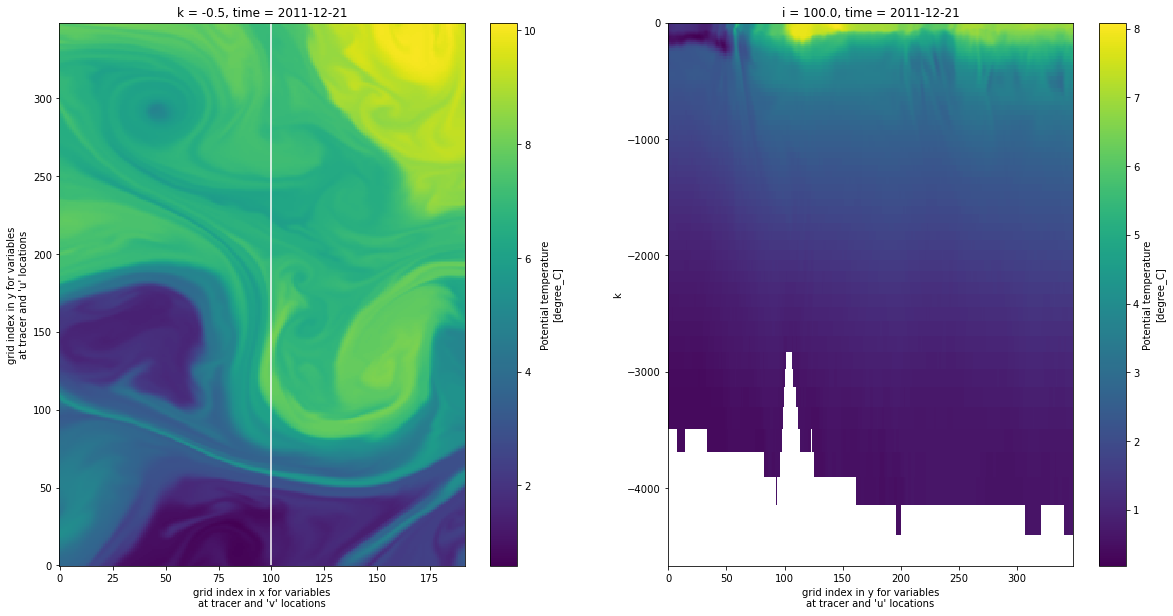

In [18]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
theta=dd0['Theta'][:]
theta.coords['k']=dd0['Z'].data

theta[0,...].plot(ax=ax[0])
ax[0].vlines(100,0,400,colors='w')
theta[:,:,100].plot(ax=ax[1])